In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
#from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
#from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
#import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
from utils import u_plot
import salem

import io
import xarray as xr

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (40., 40.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [4]:
cmip_models = ['MPI-ESM1-2-LR', 'CESM2', 'IPSL-CM6A-LR', 'EC-Earth3', 'CNRM-CM6-1']#, 'EC-Earth3']

In [5]:
experiments = { 'amip-lfmip-rmLC_hist' : (1980,2007), 'amip-lfmip-rmLC_fut' : (2080,2101), 'amip-lfmip-pdLC_hist' : (1980,2007), 'amip-lfmip-pdLC_fut' : (2080,2101)}

In [6]:
def get_month(mtag, experiments):
    
    struc = {}
    
    pup = 60000
    pdown = 85000
    months = mtag
    
    for exp in experiments:
    
#         exp ='historical'
        tas_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/tas_*'+months+'*.nc', concat_dim='model', combine='nested').load()-273.15
        uuah_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/ua_*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=slice(85000,60000)).load()
        uvah_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/va_*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=slice(85000,60000)).load()
        uah_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/ua_*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=pup).load()
        vah_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/va_*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=pup).load()
        ual_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/ua_*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=pdown).load()
        val_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/va_*'+months+'*.nc', concat_dim='model', combine='nested').sel(plev=pdown).load()
        sh_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/hfss_*'+months+'*.nc', concat_dim='model', combine='nested').load()
        lh_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/hfls_*'+months+'*.nc', concat_dim='model', combine='nested').load()
        psl_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/psl_*'+months+'*.nc', concat_dim='model', combine='nested').load()
        
        if np.isnan(uah_hist['ua'][0].values).all():
            ipdb.set_trace()
        
        uushear_hist = uuah_hist['ua'].max('plev') - uuah_hist['ua'].min('plev')
        vvshear_hist = uvah_hist['va'].max('plev') - uvah_hist['va'].min('plev')
        maxshear = np.sqrt(uushear_hist**2+vvshear_hist**2)
        
        maxshear_sign = maxshear.copy()
        maxshear_sign.values[uushear_hist<0] = maxshear_sign.values[uushear_hist<0]*-1
        
        ef_hist = lh_hist['hfls'] / (lh_hist['hfls']+sh_hist['hfss'])
        prw_hist = xr.open_mfdataset(cnst.lmcs_drive+'CMIP6/LS3MIP/slices_30y_regrid/'+exp+'/prw_*.nc', concat_dim='model', combine='nested').load()
        
        ushear_hist = uah_hist['ua'] - ual_hist['ua']
        vshear_hist = vah_hist['va'] - val_hist['va']
        
        wsl = np.sqrt(ual_hist['ua']**2+val_hist['va']**2)
        wsh = np.sqrt(uah_hist['ua']**2+vah_hist['va']**2)
        
        grad = np.gradient(tas_hist['tas'])
        grad_ar = tas_hist['tas'].copy(deep=True)
        
        ngrad = grad[1]
        lon, lat = np.meshgrid(grad_ar.lon, grad_ar.lat)
        pos = np.where(lat<0)
        ngrad[:, pos[0], pos[1]] = ngrad[:, pos[0], pos[1]]*-1
        
        grad_ar.values = ngrad
        
        #grad_ar = grad_ar.rename({'tas':'tgrad'})
        

        
        struc[exp] = {'tas' : u_darrays.roll_lons(tas_hist['tas']),
                      'uah' : u_darrays.roll_lons(uah_hist['ua']),
                      'vah' : u_darrays.roll_lons(vah_hist['va']),
                      'ual' : u_darrays.roll_lons(ual_hist['ua']),
                      'val' : u_darrays.roll_lons(val_hist['va']),
                      'sh' : u_darrays.roll_lons(sh_hist['hfss']),
                      'lh' : u_darrays.roll_lons(lh_hist['hfls']),
                      'ushear' : u_darrays.roll_lons(ushear_hist),
                      'vshear' : u_darrays.roll_lons(vshear_hist),
                      'ushear_max' : u_darrays.roll_lons(uushear_hist),
                      'vshear_max' : u_darrays.roll_lons(vvshear_hist),
                      'shear' : u_darrays.roll_lons(maxshear),
                      'shear_sign' : u_darrays.roll_lons(maxshear_sign),
                      'ef' : u_darrays.roll_lons(ef_hist),
                      'slp' : u_darrays.roll_lons(psl_hist['psl']),
                      'wsl' : u_darrays.roll_lons(wsl),
                      'wsh' : u_darrays.roll_lons(wsh),
                      'tgrad' : u_darrays.roll_lons(grad_ar),
                      'prw' : u_darrays.roll_lons(prw_hist['prw'])}
        
    return struc

In [7]:
DJF_struc = get_month('NDJFM', experiments)
JJA_struc = get_month('MJJAS', experiments)

/home/ck/miniforge3/lib/python3.12/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


In [8]:
finmask = np.isfinite(DJF_struc['amip-lfmip-rmLC_fut']['tas'][0,:,:].sel(lat=slice(-45, 45), lon=slice(-130, 170)))
#finmask.to_netcdf('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code/cmip_seamask.nc')

In [9]:
import matplotlib.patches as patches
def draw_map(ax, t, lat, lon, title='', levels=None, quiver=None, contour=None, clabel='', cmap='RdBu_r'):
   
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, levels=levels, extend='both')
    ax.coastlines()

    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'],scale=quiver['scale'],width=0.0005, headwidth=7)
    
    
        ## additional contour on plot   
    if contour is not None:
        contours = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors='Turquoise', linewidths=0.5 )
        #plt.clabel(contours, inline=True, fontsize=7, fmt='%1.1f')
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey');
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

In [10]:
def get_var(VAR, mtag):

    ename = list(experiments.keys())
    #latbox = [-45,45]
   
    if mtag == 'MJJAS':
        instruc = JJA_struc
    if mtag == 'NDJFM':
        instruc = DJF_struc

    hist = (instruc[ename[0]][VAR]).mean('model').sel(lat=slice(-45, 45), lon=slice(-130, 170))#.sel(lat=slice(latbox[0], latbox[1]))
    fut = (instruc[ename[1]][VAR]).mean('model').sel(lat=slice(-45, 45), lon=slice(-130, 170))#.sel(lat=slice(latbox[0], latbox[1]))
    ahist = (instruc[ename[2]][VAR]).mean('model').sel(lat=slice(-45, 45), lon=slice(-130, 170))#.sel(lat=slice(latbox[0], latbox[1]))
    afut = (instruc[ename[3]][VAR]).mean('model').sel(lat=slice(-45, 45), lon=slice(-130, 170))#.sel(lat=slice(latbox[0], latbox[1]))
    
    return hist, fut, ahist, afut

In [11]:
def get_var_model(VAR, mtag,model):

    ename = list(experiments.keys())
    latbox = [-45,45]

    if mtag == 'MJJAS':
        instruc = JJA_struc
    if mtag == 'NDJFM':
        instruc = DJF_struc

    hist = (instruc[ename[0]][VAR]).isel(model=model).sel(lat=slice(-45, 45), lon=slice(-130, 170))
    fut = (instruc[ename[1]][VAR]).isel(model=model).sel(lat=slice(-45, 45), lon=slice(-130, 170))
    ahist = (instruc[ename[2]][VAR]).isel(model=model).sel(lat=slice(-45, 45), lon=slice(-130, 170))
    afut = (instruc[ename[3]][VAR]).isel(model=model).sel(lat=slice(-45, 45), lon=slice(-130, 170))
    
    return hist, fut, ahist, afut

In [12]:
shear_diff = []
shs_diff = []
tas_diff = []

for mtag in ['NDJFM', 'MJJAS']:

    hist, fut, ahist, afut = get_var('sh', mtag)
    shdiff =  (fut-afut)
    shs_diff.append(shdiff)

    hist, fut, ahist, afut = get_var('tas', mtag)
    tasdiff =  fut-afut
    tas_diff.append(tasdiff)
    
    hist, fut, ahist, afut = get_var('shear', mtag)
    sheardiff = fut-afut
    shear_diff.append(sheardiff)

In [13]:
# mshear_diff = []
# mshs_diff = []
# mtas_diff = []
# mix = 0

# for mtag in ['NDJFM', 'MJJAS']:

#     hist, fut, ahist, afut = get_var_model('sh', mtag, mix)
#     shdiff =  (fut-afut)
#     mshs_diff.append(shdiff)
    
#     hist, fut, ahist, afut = get_var_model('tas', mtag, mix)
#     tasdiff =  (fut-afut)
#     mtas_diff.append(tasdiff)
    
#     hist, fut, ahist, afut = get_var_model('ushear', mtag, mix)
#     sheardiff = (fut-afut)
#     mshear_diff.append(sheardiff)

In [14]:
mshear_diff = []
mshs_diff = []
mtas_diff = []
mix = 0
mtag = 'NDJFM'
for mmix in range(0,5):

    hist, fut, ahist, afut = get_var_model('sh', mtag, mmix)
    shdiff =  (fut-afut)
    mshs_diff.append(shdiff)
    
    hist, fut, ahist, afut = get_var_model('tas', mtag, mmix)
    tasdiff =  (fut-afut)
    mtas_diff.append(tasdiff)
    
ndj_pos = (xr.concat(mshs_diff, dim='models')>0).sum('models')
ndj_neg = (xr.concat(mshs_diff, dim='models')<0).sum('models')

ndj_pos_tas = ((xr.concat(mtas_diff, dim='models')>0) & (xr.concat(mshs_diff, dim='models')>0)).sum('models')
ndj_neg_tas = ((xr.concat(mtas_diff, dim='models')<0) & (xr.concat(mshs_diff, dim='models')<0)).sum('models')

In [15]:
mshear_diff = []
mshs_diff = []
mtas_diff = []
mix = 0
mtag = 'MJJAS'
for mmix in range(0,5):

    hist, fut, ahist, afut = get_var_model('sh', mtag, mmix)
    shdiff =  (fut-afut)
    mshs_diff.append(shdiff)
    
    hist, fut, ahist, afut = get_var_model('tas', mtag, mmix)
    tasdiff =  (fut-afut)
    mtas_diff.append(tasdiff)
    
mjj_pos = (xr.concat(mshs_diff, dim='models')>0).sum('models')
mjj_neg = (xr.concat(mshs_diff, dim='models')<0).sum('models')

mjj_pos_tas = ((xr.concat(mtas_diff, dim='models')>0) & (xr.concat(mshs_diff, dim='models')>0)).sum('models')
mjj_neg_tas = ((xr.concat(mtas_diff, dim='models')<0) & (xr.concat(mshs_diff, dim='models')<0)).sum('models')

In [16]:
mjj_shtas = (mjj_pos_tas + mjj_neg_tas) > 4
ndj_shtas = (ndj_pos_tas + ndj_neg_tas) > 4

In [17]:
(ndj_pos_tas + ndj_neg_tas).max()

<xarray.DataArray ()> Size: 8B
array(5)
Coordinates:
    height   float64 8B 2.0

In [18]:
# mjj_poor = (mjj_pos_tas + mjj_neg_tas) > 1
# ndj_poor = (ndj_pos_tas + ndj_neg_tas) > 1

In [19]:
# mjj = (mjj_pos >= 4) | (mjj_neg >= 4)
# ndj = (ndj_pos >= 4) | (ndj_neg >= 4)

In [20]:
shear_merge = shear_diff[1].copy(deep=True)
sh_merge = shs_diff[1].copy(deep=True)
tas_merge = tas_diff[1].copy(deep=True)

lon, lat = np.meshgrid(shear_merge.lon, shear_merge.lat)
shear_merge.values[lat<0] = shear_diff[0].values[lat<0]
sh_merge.values[lat<0] = shs_diff[0].values[lat<0]
tas_merge.values[lat<0] = tas_diff[0].values[lat<0]

In [21]:
# sign_merge = mjj.copy(deep=True)
# sign_merge.values[lat<0] = ndj.values[lat<0]
# sign_merge.values = sign_merge.values.astype(int)

In [22]:
sign_merge = mjj_shtas.copy(deep=True)
sign_merge.values[lat<0] = ndj_shtas.values[lat<0]
sign_merge.values = sign_merge.values.astype(int)
#sign_merge.to_netcdf('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code/cmip_tas-SH-mask_stippling.nc')

In [23]:
# sign_poor = mjj_poor.copy(deep=True)
# sign_poor.values[lat<0] = ndj_poor.values[lat<0]
# sign_poor.values = sign_poor.values.astype(int)

In [24]:
smask = xr.open_dataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/ERA5_monthly_0.7deg_static.nc')['lsm'].squeeze()
smask = u_darrays.flip_lat(smask)
smask = smask.sel(latitude=slice(-45, 45), longitude=slice(-130, 170))

grid = smask.salem.grid.regrid(factor=0.5)
grid_coords = grid.to_dataset()
smask_degraded = grid.lookup_transform(smask, method=np.mean)
smask_degraded = xr.DataArray(smask_degraded, coords=[grid_coords['y'], grid_coords['x']], dims=['latitude', 'longitude'])

shear_merge = shear_diff[1].copy(deep=True)
sh_merge = shs_diff[1].copy(deep=True)
tas_merge = tas_diff[1].copy(deep=True)

lon, lat = np.meshgrid(shear_merge.lon, shear_merge.lat)
shear_merge.values[lat<0] = shear_diff[0].values[lat<0]
sh_merge.values[lat<0] = shs_diff[0].values[lat<0]
tas_merge.values[lat<0] = tas_diff[0].values[lat<0]

In [25]:
norm = u_plot.discrete_cmap_norm([1,4,7,10,13], 'jet')

In [26]:
import matplotlib.patches as patches
def draw_map_pixel(ax, t, lat, lon, title='', clabel='', cmap='RdBu_r', bottom_label=True, **kwargs):
    
    plt.pcolormesh(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, **kwargs)
    ax.coastlines()
    
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True, linewidth=0.5, color='grey', linestyle='dashed');
    #ax.set_xticks(np.arange(-140,161,20), minor=True)
    plt.grid(which='minor')
    
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    xl.bottom_labels = bottom_label
    # Countries
    #ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey', linewidth=0.5);
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

In [27]:
MREGIONS = {
 'GPlains_N' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-99,-96,42,44], 'GPlains', 'MJJAS', [5,6,7,8,9]], # # 18
 'GPlains_S' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-98,-95,36,39], 'GPlains', 'MJJAS', [5,6,7,8,9]], # # 18
 'china_W' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [105,107,29,31], 'china', 'MJJAS', [5,6,7,8,9]], # 4
 'china_E' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [111,113,25,27], 'china', 'MJJAS', [5,6,7,8,9]], # 4
 'india_N' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [74,76,24,26], 'india', 'MJJAS', [5,6,7,8,9]], # 7
 'india_S' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [76,79,18,21], 'india', 'MJJAS', [5,6,7,8,9]], # 7
 'WAf_N' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-5,5,14,16], 'WAf', 'MJJAS', [5,6,7,8,9]], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'WAf_S' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-5,5,7,9], 'WAf', 'MJJAS', [5,6,7,8,9]],
 'australia_S' : [[120,140,-27, -15], 'asia', 9, (10,12), (1,5), (1,12), [125,134, -21,-18], 'australia', 'NDJFM', [11,12,1,2,3]], # 3
 'australia_N' : [[120,140,-27, -15], 'asia', 9, (10,12), (1,5), (1,12), [125,134, -17,-15], 'australia', 'NDJFM', [11,12,1,2,3]],
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (1,5), (1,12), [21,24.5,-28,-24], 'SAf', 'NDJFM', [11,12,1,2,3]], # 10
 'sub_SA_S' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-33,-30], 'sub_SA', 'NDJFM', [11,12,1,2,3]],  # 16
 'sub_SA_N' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-28,-22], 'sub_SA', 'NDJFM', [11,12,1,2,3]]  # 16
# 'trop_SA' : [[-75, -50, -20, -5], 'spac', -5, (1,12), (1,12), (1,12)], # 17

}
S_REGION = 'china_W'
REGION = MREGIONS[S_REGION][7]

In [28]:
def density_plot(v1,v2):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

from metpy.calc import basic
from metpy.units import units
from metpy.constants import default

<>:238: SyntaxWarning: invalid escape sequence '\D'
<>:332: SyntaxWarning: invalid escape sequence '\D'
<>:341: SyntaxWarning: invalid escape sequence '\D'
<>:238: SyntaxWarning: invalid escape sequence '\D'
<>:332: SyntaxWarning: invalid escape sequence '\D'
<>:341: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_17085/781249024.py:238: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title('$\Delta$FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10)
/tmp/ipykernel_17085/781249024.py:332: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title('$\Delta$FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10)
/tmp/ipykernel_17085/781249024.py:341: SyntaxWarning: invalid escape sequence '\D'
  ax1.set_title('$\Delta$FUT  | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10)
/home/ck/miniforge3/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not used

AttributeError: 'GeoContourSet' object has no attribute 'collections'

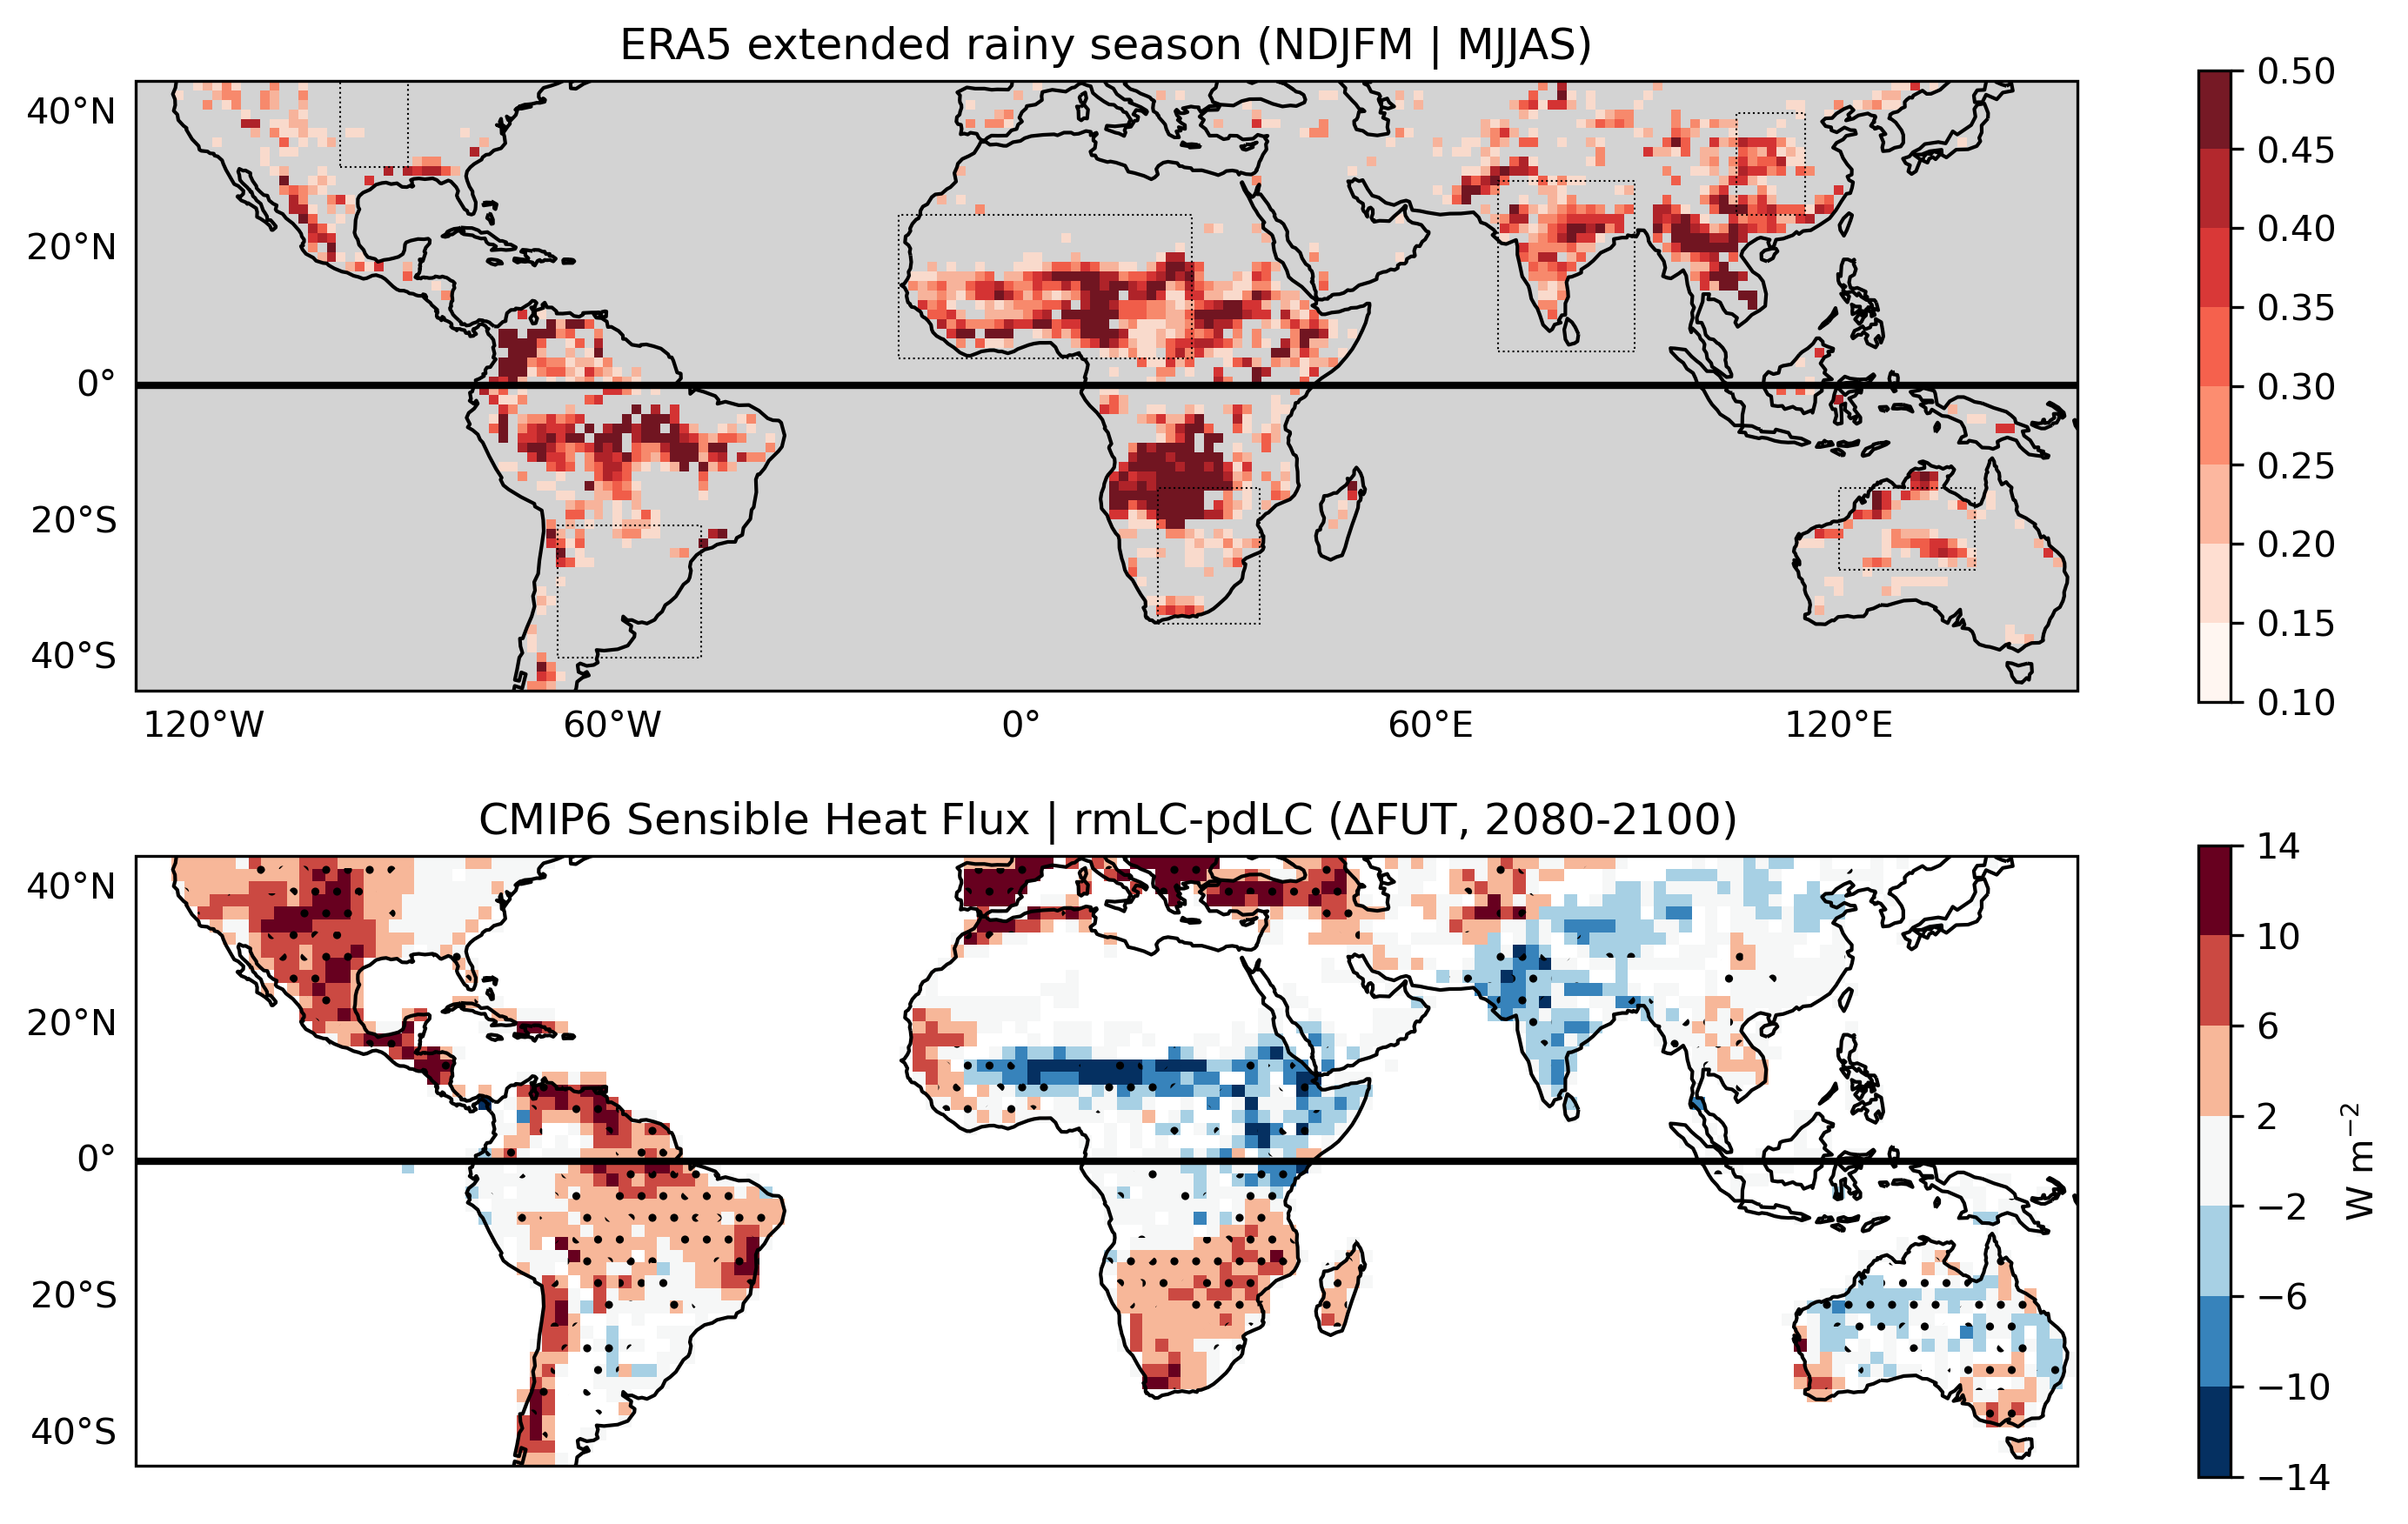

In [29]:
MREGIONS = {
 'GPlains' : [[-100,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-99,-96,42,44], 'GPlains', 'MJJAS', [5,6,7,8,9]], # # 18
 'china' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [105,107,29,31], 'china', 'MJJAS', [5,6,7,8,9]], # 4
 'india' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [74,76,24,26], 'india', 'MJJAS', [5,6,7,8,9]], # 7
 'WAf' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-5,5,14,16], 'WAf', 'MJJAS', [5,6,7,8,9]], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'australia' : [[120,140,-27, -15], 'asia', 9, (10,12), (1,5), (1,12), [125,134, -21,-18], 'australia', 'NDJFM', [11,12,1,2,3]], # 3
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (1,5), (1,12), [21,24.5,-28,-24], 'SAf', 'NDJFM', [11,12,1,2,3]], # 10
 'sub_SA' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-33,-30], 'sub_SA', 'NDJFM', [11,12,1,2,3]],  # 16
}


corr_ds = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/correlations_new_degraded/sh_versus_ushear_plusMinus3deg_meridional_*.nc', concat_dim='month', combine='nested')
corr_dst = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/correlations_new_degraded/t2_versus_ushear_plusMinus3deg_meridional_*.nc', concat_dim='month', combine='nested')


left, width, width2, height = 0.061, 0.93, 0.22, 0.22#0.345, 0.3
space=0.01
xspace=0.03
bottom=0.08
left2 = left + width + left

p1 = [left, bottom+height+space, width, height]
p2 = [left, bottom+2*height+space+0.02, width, height]
p3 = [left, bottom+3*height+3*space+0.05, width, height]

p4 = [left, bottom, width2, height-0.05]
p5 = [left+width2+3*xspace, bottom, width2, height-0.05]
p6 = [left+2*width2+6*xspace, bottom, width2, height-0.05]


#corr_month['r'].values[corr_month.latitude.values<0] = (corr_month['r'].values[corr_month.latitude.values<0])*-1
titles = ['JFM', 'AMJ', 'JAS', 'OND']


coll=[]

f = plt.figure(figsize=(10,11), dpi=300)
for idx, cs in enumerate([(11,12,1,2,3), (5,6,7,8,9)]):
    norm = u_plot.discrete_cmap_norm(np.arange(0.1,0.51,0.05), 'Reds')

    #corr_month = corr_ds.sel(month=corr_ds.month.isin(cs)).mean('month')
    
    corr_months = corr_ds.sel(month=corr_ds.month.isin(cs))
    corr_months_t = corr_dst.sel(month=corr_dst.month.isin(cs))
    
    corr_months = corr_months.where(((corr_months['r']>0) & (corr_months_t['r']>0)) | ((corr_months['r']<0) & (corr_months_t['r']<0)))
    
    if idx == 0:
        corr_months = corr_months.where(corr_months.latitude < 0)
    else:
        corr_months = corr_months.where(corr_months.latitude > 0)
        
    corr_max = (corr_months['r']**2).max('month')
    corr_pval = corr_months['pval'].where(corr_months['r']**2==corr_max).mean('month')
    #corr_max = corr_months['r'].where(np.abs(corr_months['r']**2)==corr_abs).max('month')
   

    coll.append(corr_max.where((corr_pval<0.01) & (smask_degraded>0.98)))  # smask__degraded
    
merge = xr.concat(coll, dim='idx')

corr_max = merge.mean('idx')

#corr_max.to_netcdf('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code/era5_correlation_sh_versus_ushear_rainySeason.nc')

#ax = f.add_subplot(321, projection=ccrs.PlateCarree())
ax = plt.axes(p3, projection=ccrs.PlateCarree())

draw_map_pixel(ax, corr_max , corr_months.latitude, corr_months.longitude, title='', clabel='', cmap='Reds', norm=norm, alpha=0.9) #corr_month['pval']<0.01) &
ax.set_xlim(-130,155)

#ax.set_ylim(-60,60)
plt.title('ERA5 extended rainy season (NDJFM | MJJAS)')
ax.axhline(0, linestyle='solid', linewidth=2, color='k')

for reg in MREGIONS.keys():
#     box = MREGIONS[reg][6]
#     rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=2,edgecolor='turquoise', zorder=99, fill=False)
    #ax.add_patch(rect2)
    box = MREGIONS[reg][0]
    rect1 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.5,edgecolor='k', zorder=99, fill=False, linestyle='dotted')
    ax.add_patch(rect1)

#f.savefig('/home/ck/DIR/cornkle/figs/LMCS/CMIP_LS3MIP/ERA5_only/sh_ushear_correlation_map_corrfac_meridional.png')
ax.set_facecolor('lightgrey')



###########################


#ax = f.add_subplot(323, projection=ccrs.PlateCarree())
ax = plt.axes(p2, projection=ccrs.PlateCarree())
norm = u_plot.discrete_cmap_norm([-14,-10,-6,-2,2,6,10,14], 'RdBu')

tasmask = ((sh_merge>0) & (tas_merge>0)) | ((sh_merge<0) & (tas_merge<0))

draw_map_pixel(ax, sh_merge.where(finmask&tasmask),sh_merge.lat, sh_merge.lon, title=r'CMIP6 Sensible Heat Flux | rmLC-pdLC ($\Delta$FUT, 2080-2100)', clabel=r'W m$^{-2}$', norm=norm, bottom_label=False) #np.percentile(k, np.arange(5,91,11) 'W m$^{-2}$'
ax.set_xlim(-130,155)

ax.axhline(0, linestyle='solid', linewidth=2, color='k')
cs = plt.contourf(sh_merge.lon, sh_merge.lat, sign_merge.where((finmask), other=0), colors='none', hatches=['..'], levels=[0.5,1], linewidth=0.1)
# For each level, we set the color of its hatch 
for i, collection in enumerate(cs.collections):
    collection.set_edgecolor('purple')
for collection in cs.collections:
    collection.set_linewidth(0.)


for reg in MREGIONS.keys():
#     box = MREGIONS[reg][6]
#     rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=2,edgecolor='turquoise', zorder=99, fill=False)
    #ax.add_patch(rect2)
    box = MREGIONS[reg][0]
    rect1 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.5,edgecolor='k', zorder=99, fill=False, linestyle='dotted')
    ax.add_patch(rect1)
ax.set_facecolor('lightgrey')
    
#ax = f.add_subplot(325, projection=ccrs.PlateCarree())
ax = plt.axes(p1, projection=ccrs.PlateCarree())
norm = u_plot.discrete_cmap_norm([-0.8,-0.6,-0.4, -0.2, 0.2, 0.4,0.6,0.8], 'RdBu')
draw_map_pixel(ax, shear_merge.where(finmask&tasmask) ,shear_merge.lat, shear_merge.lon, title=r'CMIP6 650-850hPa shear | rmLC-pdLC ($\Delta$FUT, 2080-2100)', norm=norm, clabel=r'm s$^{-1}$') #np.percentile(k, np.arange(5,91,11)

ax.set_xlim(-130,155)
ax.axhline(0, linestyle='solid', linewidth=2, color='k')

plt.contour(sh_merge.lon, sh_merge.lat, np.abs(sh_merge.where((finmask&tasmask), other=0)), levels=[-1000,4,8], colors='purple', linewidths=0.5)

for reg in MREGIONS.keys():
#     box = MREGIONS[reg][6]
#     rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=2,edgecolor='turquoise', zorder=99, fill=False)
    #ax.add_patch(rect2)
    box = MREGIONS[reg][0]
    rect1 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.5,edgecolor='k', zorder=99, fill=False, linestyle='dotted')
    ax.add_patch(rect1)
ax.set_facecolor('lightgrey')

# sh_merge.to_netcdf('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code/cmip_sh.nc')
# shear_merge.to_netcdf('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code/cmip_ushear.nc')
# tas_merge.to_netcdf('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code/cmip_tas.nc')
# smask_degraded.to_netcdf('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code/era_seamask.nc')

############################



colors = ['red', 'orange', 'gold', 'brown', 'blue', 'purple', 'violet']
lss = ['solid', 'solid', 'solid', 'solid', 'dashed', 'dashed', 'dashed']

tgrad_list = []
shear_list = []
#ax = f.add_subplot(324)
ax = plt.axes(p6)
for ids, reg in enumerate((list(MREGIONS.keys()))):

        mtag = MREGIONS[reg][8]
        lbox = MREGIONS[reg][0]

        VAR1='tas'
        VAR2='ushear'
        VAR3 = 'sh'

        for idm, model in enumerate(cmip_models):
            hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
            hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)
            hist3, fut3, ahist3, afut3 = get_var_model(VAR3, mtag, idm)

            era_t = fut-afut
            era_ushear = fut2-afut2
            era_sh = fut3-afut3
            
            era_t = era_t.where(((era_sh>0)&(era_t>0)) | ((era_sh<0)&(era_t<0)))
            
            era_t = era_t.where(finmask)
            era_ushear = era_ushear.where(finmask)

            plons = era_t.lon.where((era_t.lon >=lbox[0]) & (era_t.lon <=lbox[1]), drop=True)
            plats = era_t.lat.where((era_t.lat >=lbox[2]) & (era_t.lat <=lbox[3]), drop=True)

            plon, plat = np.meshgrid(plons[0::2], plats[0::2])

            shears = []
            tgrads = []
            x_tgrad = 3
            x_shear = 2

            for zlon, zlat in zip(plon.flatten(), plat.flatten()):


                zlon = int(np.round(zlon))
                zlat = int(np.round(zlat))
                
                erashear_vals = era_ushear.sel(lat=slice(zlat-x_shear,zlat+x_shear+1), lon=slice(zlon-x_shear,zlon+x_shear+1))
                erat_vals = era_t.sel(lat=slice(zlat-x_tgrad,zlat+x_tgrad+1), lon=slice(zlon-x_tgrad,zlon+x_tgrad+1))
                
                if (np.sum(np.isnan(erashear_vals))>0) | (np.sum(np.isnan(erat_vals))>1) | (np.sum(np.isnan(erat_vals.mean(['lon'])))>0):
                    continue

                erashear_box = erashear_vals.mean(['lon','lat']).squeeze()
               
                try:
                    erat_poly = erat_vals.mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
                except RankWarning:
                    ipdb.set_trace()
               # ipdb.set_trace()

                if ids > 3:
                    erat_poly = erat_poly*-1


                shears.append(erashear_box.values)
                tgrads.append(((erat_poly['polyfit_coefficients'])[0]).values)
                #ipdb.set_trace()

            #ax.scatter(tgrads, shears, label=reg)


            ax.set_xlabel('Poleward Tgrad difference (K/deg)')
            ax.set_ylabel('Zonal shear difference (m/s)')
            ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
            ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
            tgrad_list.extend(tgrads)
            shear_list.extend(shears)
            
            
cmip_scatter = {
    'ushear' : np.array(shear_list),
    'tgrad' : np.array(tgrad_list)                 
}
            

data4, r4 = density_plot(tgrad_list, shear_list)
ax.scatter(tgrad_list, shear_list , c=data4, cmap='viridis_r', s=15)          

isfinites = (np.isfinite(shear_list)) & np.isfinite(tgrad_list)
#ipdb.set_trace()
pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[isfinites], np.array(shear_list)[isfinites])
ax.set_title('$\Delta$FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 
print('length tlist', len(tgrad_list))
sgrad_list = []
shear_list = []
colors = []
#ax = f.add_subplot(326)


ax = plt.axes(p5)
ax1 = plt.axes(p4)
cnt = 0
for ids, reg in enumerate((list(MREGIONS.keys()))):

        mtag = MREGIONS[reg][8]
        lbox = MREGIONS[reg][0]

        VAR1='tas'
        VAR2='ushear'
        VAR3 = 'sh'

        for idm, model in enumerate(cmip_models):
            hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
            hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)
            hist3, fut3, ahist3, afut3 = get_var_model(VAR3, mtag, idm)

            era_sh = fut-afut
            era_ushear = fut2-afut2
            era_t = fut3-afut3
            
            era_t = era_t.where(((era_sh>0)&(era_t>0)) | ((era_sh<0)&(era_t<0)))
            
            era_t = era_t.where(finmask)
            era_ushear = era_ushear.where(finmask)


            plons = era_t.lon.where((era_t.lon >=lbox[0]) & (era_t.lon <=lbox[1]), drop=True)
            plats = era_t.lat.where((era_t.lat >=lbox[2]) & (era_t.lat <=lbox[3]), drop=True)

            plon, plat = np.meshgrid(plons[0::2], plats[0::2])

            shears = []
            tgrads = []
            x_tgrad = 3
            x_shear = 2

            for zlon, zlat in zip(plon.flatten(), plat.flatten()):


                zlon = int(np.round(zlon))
                zlat = int(np.round(zlat))
                
                erashear_vals = era_ushear.sel(lat=slice(zlat-x_shear,zlat+x_shear+1), lon=slice(zlon-x_shear,zlon+x_shear+1))
                erat_vals = era_t.sel(lat=slice(zlat-x_tgrad,zlat+x_tgrad+1), lon=slice(zlon-x_tgrad,zlon+x_tgrad+1))
                
                if (np.sum(np.isnan(erashear_vals))>0) |  (np.sum(np.isnan(erat_vals))>1) | (np.sum(np.isnan(erat_vals.mean(['lon'])))>0):
                    continue

                erashear_box = erashear_vals.mean(['lon','lat']).squeeze()
               
                try:
                    erat_poly = erat_vals.mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
                except RankWarning:
                    ipdb.set_trace()
               # ipdb.set_trace()

                if ids > 3:
                    erat_poly = erat_poly*-1


                shears.append(erashear_box.values)
                tgrads.append(((erat_poly['polyfit_coefficients'])[0]).values)
                #ipdb.set_trace()

            #ax.scatter(tgrads, shears, label=reg)

            sgrad_list.extend(tgrads)
            shear_list.extend(shears)
            
cmip_scatter['sh'] = np.array(sgrad_list)
#cmip_scat = xr.Dataset.from_dict(cmip_scatter)

# cmip_scat = pd.DataFrame.from_dict(cmip_scatter)
# cmip_scat.to_csv('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code/cmip_scatter.csv')


data4, r4 = density_plot(sgrad_list, shear_list)
ax.scatter(sgrad_list, shear_list , c=data4, cmap='viridis_r', s=15)  
ax.set_xlabel('Poleward Hgrad difference (W/m$^{-2}$)')
ax.set_ylabel('Zonal shear difference (m/s)')
ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
      
isfinites = (np.isfinite(shear_list)) & np.isfinite(tgrad_list)
pf, intercept, rval, p, std_err = stats.linregress(np.array(sgrad_list)[isfinites], np.array(shear_list)[isfinites])
ax.set_title('$\Delta$FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 

data4, r4 = density_plot(sgrad_list, tgrad_list)
ax1.scatter(sgrad_list, tgrad_list , c=data4, cmap='viridis_r', s=15)  
ax1.set_xlabel('Poleward Hgrad difference (W/m$^{-2}$)')
ax1.set_ylabel('Poleward Tgrad difference (K/deg)')
ax1.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
ax1.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
pf, intercept, rval, p, std_err = stats.linregress(np.array(sgrad_list)[isfinites], np.array(tgrad_list)[isfinites])
ax1.set_title('$\Delta$FUT  | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 



plt.annotate('(a)', xy=(0.03, 1.01), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
plt.annotate('(b)', xy=(0.03, 0.74), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
plt.annotate('(c)', xy=(0.03, 0.5), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
plt.annotate('(d)', xy=(0.03, 0.23), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
plt.annotate('(e)', xy=(0.33, 0.23), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
plt.annotate('(f)', xy=(0.65, 0.23), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')



In [30]:
from utils import u_statistics as us

<>:254: SyntaxWarning: invalid escape sequence '\D'
<>:348: SyntaxWarning: invalid escape sequence '\D'
<>:357: SyntaxWarning: invalid escape sequence '\D'
<>:254: SyntaxWarning: invalid escape sequence '\D'
<>:348: SyntaxWarning: invalid escape sequence '\D'
<>:357: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_17085/4121486454.py:254: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title('$\Delta$FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10)
/tmp/ipykernel_17085/4121486454.py:348: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title('$\Delta$FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10)
/tmp/ipykernel_17085/4121486454.py:357: SyntaxWarning: invalid escape sequence '\D'
  ax1.set_title('$\Delta$FUT  | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10)
/home/ck/miniforge3/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: The following kwargs were not u

pears PearsonRResult(statistic=np.float64(-0.7373222635606398), pvalue=np.float64(3.879943443851474e-44))
length tlist 250
pears PearsonRResult(statistic=np.float64(-0.5225459424983513), pvalue=np.float64(6.425257283085295e-19))
pears PearsonRResult(statistic=np.float64(0.7321317455541478), pvalue=np.float64(3.0511607507629972e-43))


/tmp/ipykernel_17085/4121486454.py:376: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  f.savefig('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code_v2/fig4.eps')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/ck/miniforge3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/ck/miniforge3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


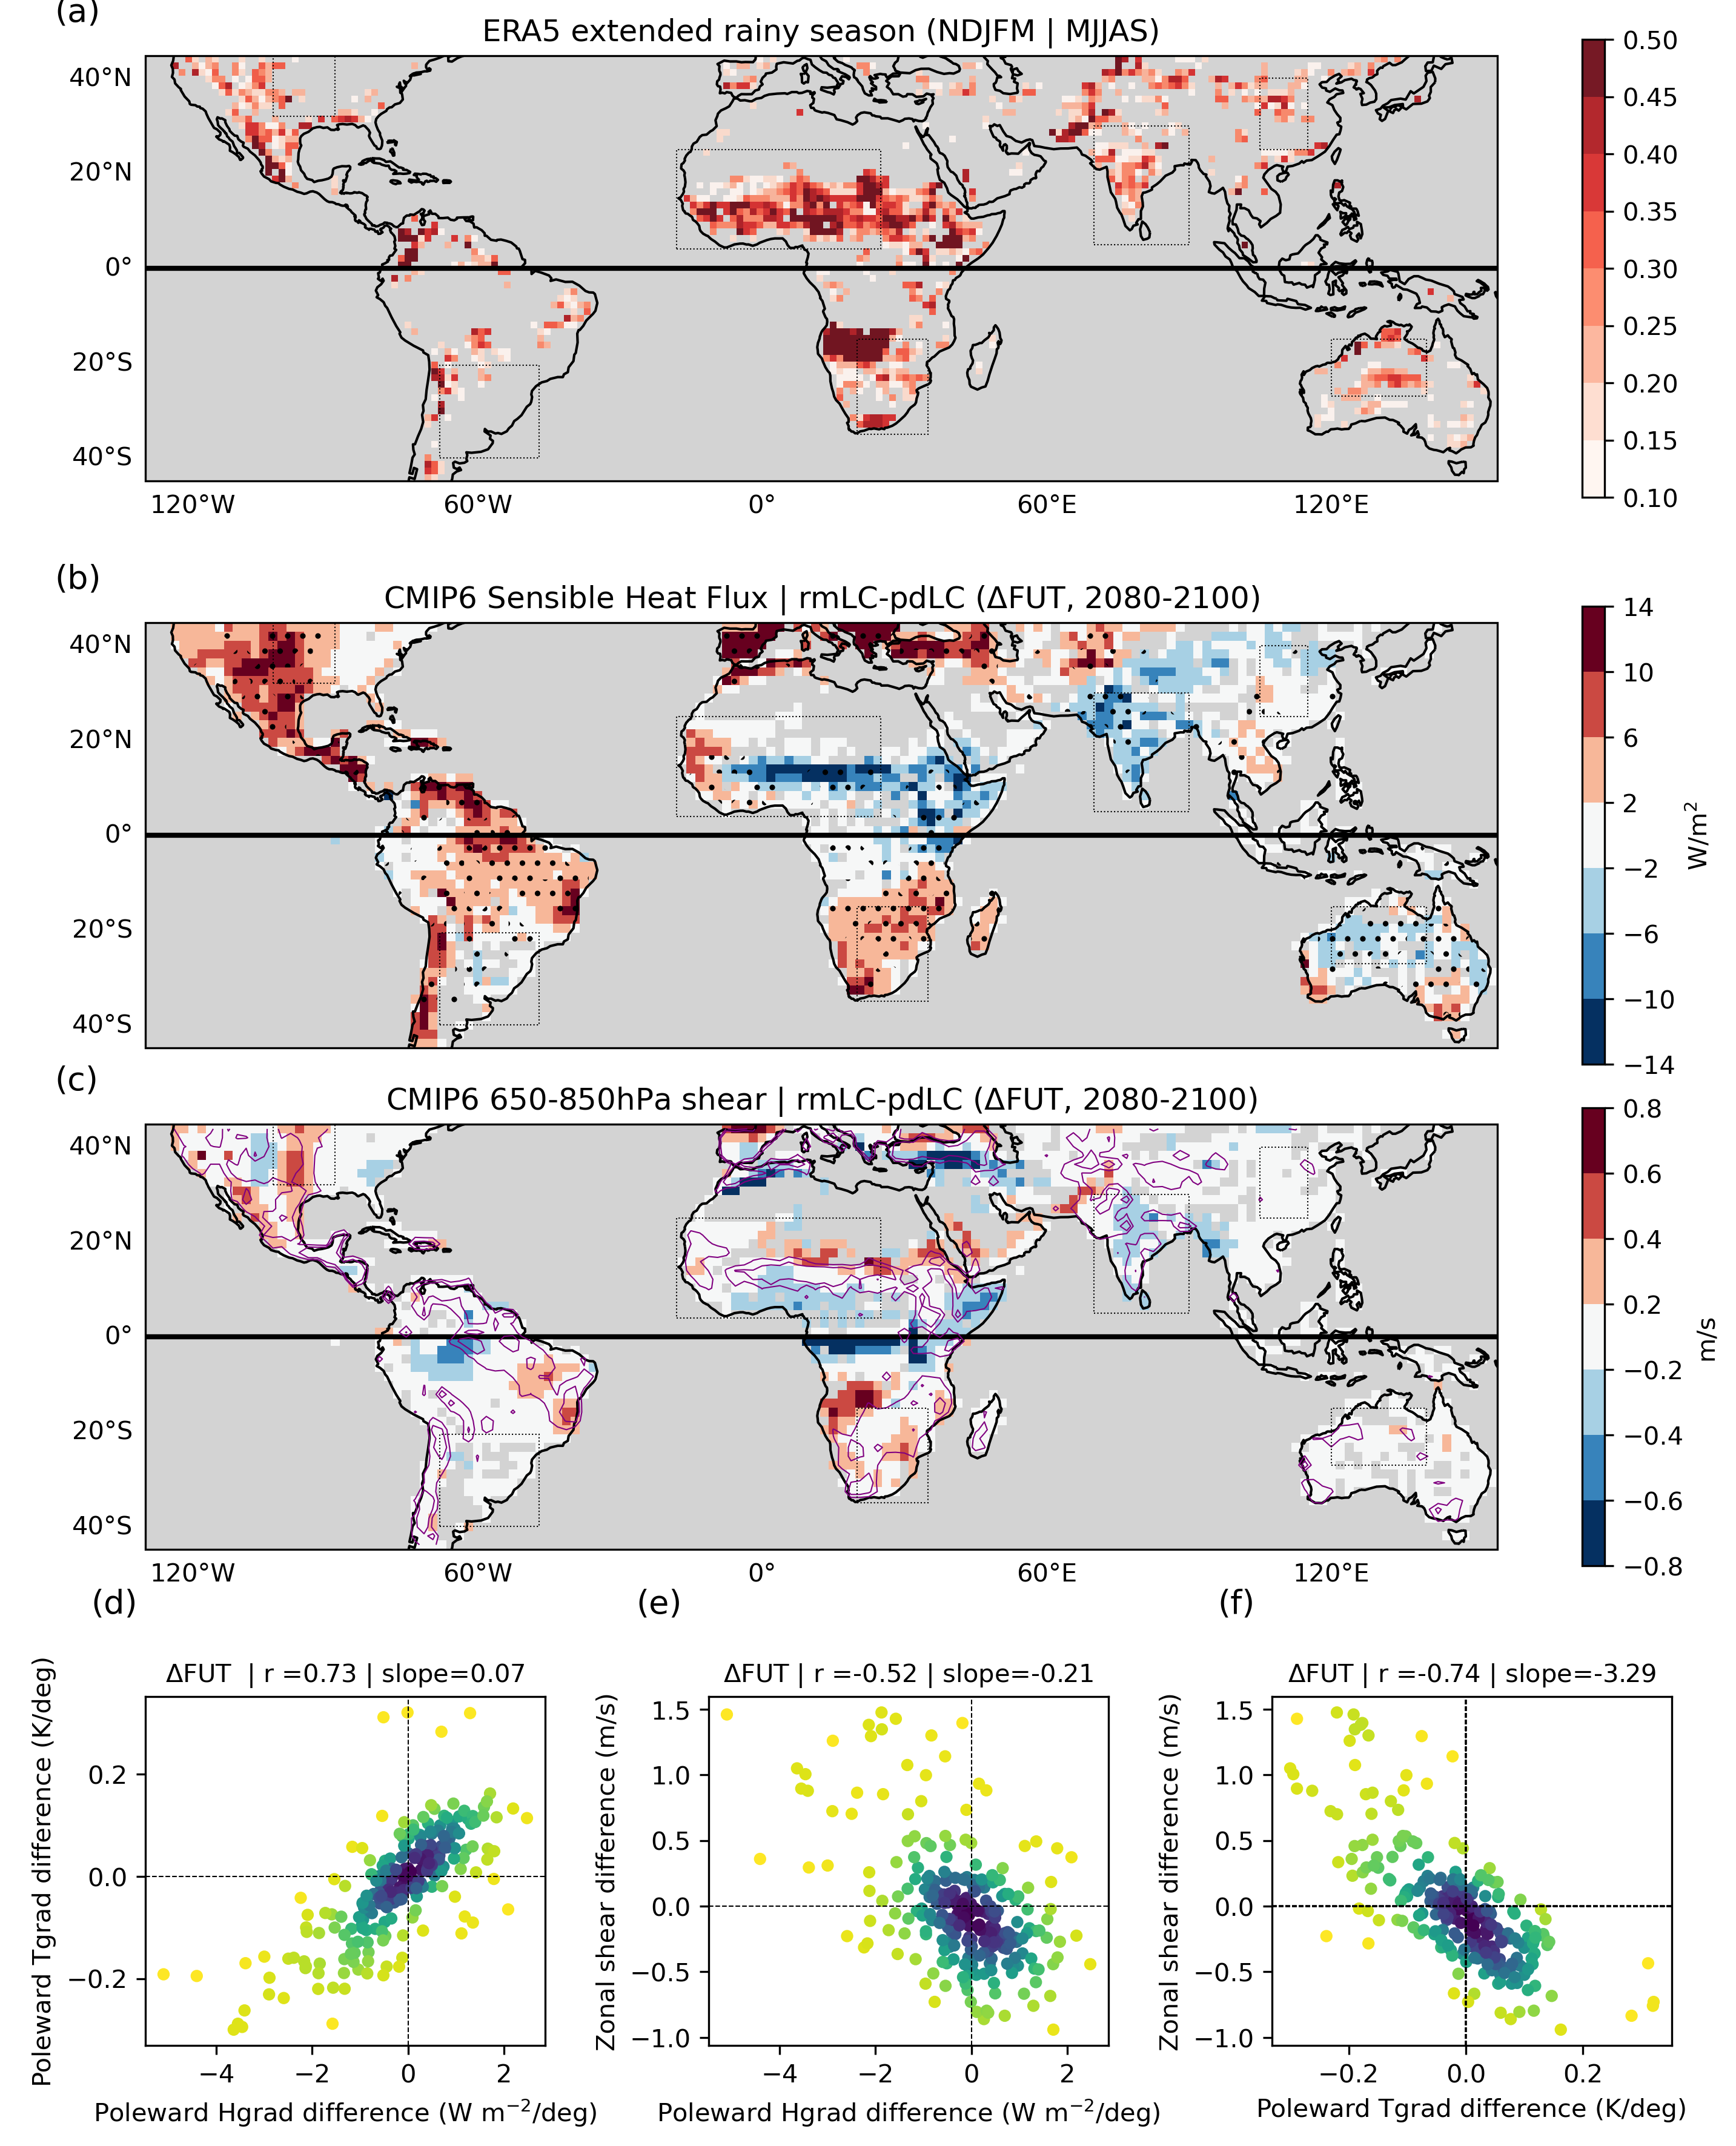

In [54]:
MREGIONS = {
 'GPlains' : [[-103,-90,32,47], 'nam', -6, (1,7), (8,12), (1,12), [-99,-96,42,44], 'GPlains', 'MJJAS', [5,6,7,8,9]], # # 18
 'china' : [[105,115,25,40], 'asia', 8 , (1,7), (8,12), (1,12), [105,107,29,31], 'china', 'MJJAS', [5,6,7,8,9]], # 4
 'india' : [[70,90, 5,30], 'asia', 5, (1,7), (8,12), (1,12), [74,76,24,26], 'india', 'MJJAS', [5,6,7,8,9]], # 7
 'WAf' : [[-18,25,4,25], 'spac', 0, (1,7), (8,12), (1,12), [-5,5,14,16], 'WAf', 'MJJAS', [5,6,7,8,9]], # last is hourly offset to UCT # 12    # [-18,25,4,25]
 'australia' : [[120,140,-27, -15], 'asia', 9, (10,12), (1,5), (1,12), [125,134, -21,-18], 'australia', 'NDJFM', [11,12,1,2,3]], # 3
 'SAf' : [[20,35, -35,-15], 'spac', 2, (9,12), (1,5), (1,12), [21,24.5,-28,-24], 'SAf', 'NDJFM', [11,12,1,2,3]], # 10
 'sub_SA' : [[-68,-47, -40, -20.5], 'spac', -4, (9,12), (1,5), (1,12), [-63,-60,-33,-30], 'sub_SA', 'NDJFM', [11,12,1,2,3]],  # 16
}


direction = 'meridional'

corr_dsl = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/correlations_new_degraded/lh_versus_ushear_plusMinus3deg_'+direction+'_*degraded.nc', concat_dim='month', combine='nested')
corr_dss = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/correlations_new_degraded/sh_versus_ushear_plusMinus3deg_'+direction+'_*degraded.nc', concat_dim='month', combine='nested')
corr_dst = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/correlations_new_degraded/t2_versus_ushear_plusMinus3deg_'+direction+'_*degraded.nc', concat_dim='month', combine='nested')
corr_ds = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/correlations_new_degraded/sm_versus_ushear_plusMinus3deg_'+direction+'_*degraded.nc', concat_dim='month', combine='nested')
#corr_dsv = xr.open_mfdataset('/media/ck/LStorage/global_water/ERA5_global_0.7/monthly/correlations_new_degraded/sm_versus_vshear_plusMinus3deg_meridional_*degraded.nc', concat_dim='month', combine='nested')

left, width, width2, height = 0.1, 0.93, 0.22, 0.21#0.345, 0.3
space=0.01
xspace=0.03
bottom=0.06
left2 = left + width + left

p1 = [left, bottom+height+space, width, height]
p2 = [left, bottom+2*height+space+0.02, width, height]
p3 = [left, bottom+3*height+3*space+0.05, width, height]

p4 = [left, bottom, width2, height-0.05]
p5 = [left+width2+3*xspace, bottom, width2, height-0.05]
p6 = [left+2*width2+6*xspace, bottom, width2, height-0.05]


#corr_month['r'].values[corr_month.latitude.values<0] = (corr_month['r'].values[corr_month.latitude.values<0])*-1
titles = ['JFM', 'AMJ', 'JAS', 'OND']


coll=[]

f = plt.figure(figsize=(10,12), dpi=300)
for idx, cs in enumerate([(11,12,1,2,3), (5,6,7,8,9)]):
    norm = u_plot.discrete_cmap_norm(np.arange(0.1,0.51,0.05), 'Reds')


    
    #corr_months = corr_ds.sel(month=corr_ds.month.isin(cs))
    corr_months = corr_ds.sel(month=corr_ds.month.isin(cs))
    
    #corr_months = (corr_months['r'].where((corr_months['pval']<0.01))**2).mean('month')
    corr_months_l = corr_dsl.sel(month=corr_dsl.month.isin(cs))
    corr_months_s = corr_dss.sel(month=corr_dss.month.isin(cs))
    corr_months_t = corr_dst.sel(month=corr_dst.month.isin(cs))
    
    poss = (corr_months['r']<0) & (corr_months_l['r']<0) & (corr_months_s['r']>0)  & (corr_months_t['r']>0)
    negg = (corr_months['r']>0) & (corr_months_l['r']>0) & (corr_months_s['r']<0)  & (corr_months_t['r']<0)
    
    corr_months = corr_months.where((poss) | (negg))
    
    if idx == 0:
        corr_months = corr_months.where(corr_months.latitude < 0)
        corr_months_s = corr_months_s.where(corr_months_s.latitude < 0)
    else:
        corr_months = corr_months.where(corr_months.latitude > 0)
        corr_months_s = corr_months_s.where(corr_months_s.latitude > 0)
        
#     pthresh_sm = us.fdr_threshold(corr_months['pval'].values[np.isfinite(corr_months['pval'].values)], alpha=0.01)
#     pthresh_sh = us.fdr_threshold(corr_months_s['pval'].values[np.isfinite(corr_months_s['pval'].values)], alpha=0.01)
#     print('pval', pthresh_sm, pthresh_sh)
    corr_max = (corr_months['r'].where((corr_months['pval']<0.05)& (corr_months_s['pval']<0.05)  )**2).max('month')  #& (corr_months_s['pval']<pthresh_sh)

   
    coll.append(corr_max.where((smask_degraded>0.98) ))  # smask__degraded
    #coll.append(corr_months.where((smask_degraded>0.98))) 
    
merge = xr.concat(coll, dim='idx')

corr_max = merge.mean('idx')

corr_max.to_netcdf('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code_v2/era5_correlation_sm_versus_ushear_rainySeason.nc')

#ax = f.add_subplot(321, projection=ccrs.PlateCarree())
ax = plt.axes(p3, projection=ccrs.PlateCarree())

draw_map_pixel(ax, corr_max , corr_months.latitude, corr_months.longitude, title='', clabel='', cmap='Reds', norm=norm, alpha=0.9) #corr_month['pval']<0.01) &
ax.set_xlim(-130,155)

#ax.set_ylim(-60,60)
plt.title('ERA5 extended rainy season (NDJFM | MJJAS)')
ax.axhline(0, linestyle='solid', linewidth=2, color='k')

for reg in MREGIONS.keys():
#     box = MREGIONS[reg][6]
#     rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=2,edgecolor='turquoise', zorder=99, fill=False)
    #ax.add_patch(rect2)
    box = MREGIONS[reg][0]
    rect1 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.5,edgecolor='k', zorder=99, fill=False, linestyle='dotted')
    ax.add_patch(rect1)

#f.savefig('/home/ck/DIR/cornkle/figs/LMCS/CMIP_LS3MIP/ERA5_only/sh_ushear_correlation_map_corrfac_meridional.png')
ax.set_facecolor('lightgrey')



###########################


#ax = f.add_subplot(323, projection=ccrs.PlateCarree())
ax = plt.axes(p2, projection=ccrs.PlateCarree())
norm = u_plot.discrete_cmap_norm([-14,-10,-6,-2,2,6,10,14], 'RdBu')

tasmask = ((sh_merge>0) & (tas_merge>0)) | ((sh_merge<0) & (tas_merge<0))

draw_map_pixel(ax, sh_merge.where(finmask&tasmask),sh_merge.lat, sh_merge.lon, title=r'CMIP6 Sensible Heat Flux | rmLC-pdLC ($\Delta$FUT, 2080-2100)', clabel=r'W/m$^{2}$', norm=norm, bottom_label=False) #np.percentile(k, np.arange(5,91,11) 'W m$^{-2}$'
ax.set_xlim(-130,155)

ax.axhline(0, linestyle='solid', linewidth=2, color='k')
cs = plt.contourf(sh_merge.lon, sh_merge.lat, sign_merge.where((finmask), other=0), colors='none', hatches=['..'], levels=[0.5,1], linewidth=0.1)
# For each level, we set the color of its hatch 
for collection in cs.get_children():
    collection.set_edgecolor('purple')
for collection in cs.get_children():
    collection.set_linewidth(0.)


for reg in MREGIONS.keys():
#     box = MREGIONS[reg][6]
#     rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=2,edgecolor='turquoise', zorder=99, fill=False)
    #ax.add_patch(rect2)
    box = MREGIONS[reg][0]
    rect1 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.5,edgecolor='k', zorder=99, fill=False, linestyle='dotted')
    ax.add_patch(rect1)
ax.set_facecolor('lightgrey')
    
#ax = f.add_subplot(325, projection=ccrs.PlateCarree())
ax = plt.axes(p1, projection=ccrs.PlateCarree())
norm = u_plot.discrete_cmap_norm([-0.8,-0.6,-0.4, -0.2, 0.2, 0.4,0.6,0.8], 'RdBu')
draw_map_pixel(ax, shear_merge.where(finmask&tasmask) ,shear_merge.lat, shear_merge.lon, title=r'CMIP6 650-850hPa shear | rmLC-pdLC ($\Delta$FUT, 2080-2100)', norm=norm, clabel=r'm/s') #np.percentile(k, np.arange(5,91,11)

ax.set_xlim(-130,155)
ax.axhline(0, linestyle='solid', linewidth=2, color='k')

plt.contour(sh_merge.lon, sh_merge.lat, np.abs(sh_merge.where((finmask&tasmask), other=0)), levels=[-1000,4,8], colors='purple', linewidths=0.5)

for reg in MREGIONS.keys():
#     box = MREGIONS[reg][6]
#     rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=2,edgecolor='turquoise', zorder=99, fill=False)
    #ax.add_patch(rect2)
    box = MREGIONS[reg][0]
    rect1 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.5,edgecolor='k', zorder=99, fill=False, linestyle='dotted')
    ax.add_patch(rect1)
ax.set_facecolor('lightgrey')

# sh_merge.to_netcdf('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code/cmip_sh.nc')
# shear_merge.to_netcdf('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code/cmip_ushear.nc')
# tas_merge.to_netcdf('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code/cmip_tas.nc')
# smask_degraded.to_netcdf('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code/era_seamask.nc')

############################



colors = ['red', 'orange', 'gold', 'brown', 'blue', 'purple', 'violet']
lss = ['solid', 'solid', 'solid', 'solid', 'dashed', 'dashed', 'dashed']

tgrad_list = []
shear_list = []
#ax = f.add_subplot(324)
ax = plt.axes(p6)
for ids, reg in enumerate((list(MREGIONS.keys()))):

        mtag = MREGIONS[reg][8]
        lbox = MREGIONS[reg][0]

        VAR1='tas'
        VAR2='ushear'
        VAR3 = 'sh'

        for idm, model in enumerate(cmip_models):
            hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
            hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)
            hist3, fut3, ahist3, afut3 = get_var_model(VAR3, mtag, idm)

            era_t = fut-afut
            era_ushear = fut2-afut2
            era_sh = fut3-afut3
            
            era_t = era_t.where(((era_sh>0)&(era_t>0)) | ((era_sh<0)&(era_t<0)))
            
            era_t = era_t.where(finmask)
            era_ushear = era_ushear.where(finmask)

            plons = era_t.lon.where((era_t.lon >=lbox[0]) & (era_t.lon <=lbox[1]), drop=True)
            plats = era_t.lat.where((era_t.lat >=lbox[2]) & (era_t.lat <=lbox[3]), drop=True)

            plon, plat = np.meshgrid(plons[0::2], plats[0::2])

            shears = []
            tgrads = []
            x_tgrad = 3
            x_shear = 2

            for zlon, zlat in zip(plon.flatten(), plat.flatten()):


                zlon = int(np.round(zlon))
                zlat = int(np.round(zlat))
                
                erashear_vals = era_ushear.sel(lat=slice(zlat-x_shear,zlat+x_shear+1), lon=slice(zlon-x_shear,zlon+x_shear+1))
                erat_vals = era_t.sel(lat=slice(zlat-x_tgrad,zlat+x_tgrad+1), lon=slice(zlon-x_tgrad,zlon+x_tgrad+1))
                
                if (np.sum(np.isnan(erashear_vals))>0) | (np.sum(np.isnan(erat_vals))>1) | (np.sum(np.isnan(erat_vals.mean(['lon'])))>0):
                    continue

                erashear_box = erashear_vals.mean(['lon','lat']).squeeze()
               
                try:
                    erat_poly = erat_vals.mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
                except RankWarning:
                    ipdb.set_trace()
               # ipdb.set_trace()

                if ids > 3:
                    erat_poly = erat_poly*-1


                shears.append(erashear_box.values)
                tgrads.append(((erat_poly['polyfit_coefficients'])[0]).values)
                #ipdb.set_trace()

            #ax.scatter(tgrads, shears, label=reg)


            ax.set_xlabel('Poleward Tgrad difference (K/deg)')
            ax.set_ylabel('Zonal shear difference (m/s)')
            ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
            ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
            tgrad_list.extend(tgrads)
            shear_list.extend(shears)
            
            
cmip_scatter = {
    'ushear' : np.array(shear_list),
    'tgrad' : np.array(tgrad_list)                 
}
            

data4, r4 = density_plot(tgrad_list, shear_list)
ax.scatter(tgrad_list, shear_list , c=data4, cmap='viridis_r', s=15)          

isfinites = (np.isfinite(shear_list)) & np.isfinite(tgrad_list)
#ipdb.set_trace()
pf, intercept, rval, p, std_err = stats.linregress(np.array(tgrad_list)[isfinites], np.array(shear_list)[isfinites])
ax.set_title('$\Delta$FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 
print('length tlist', len(tgrad_list))
sgrad_list = []
shear_list = []
colors = []
#ax = f.add_subplot(326)


ax = plt.axes(p5)
ax1 = plt.axes(p4)
cnt = 0
for ids, reg in enumerate((list(MREGIONS.keys()))):

        mtag = MREGIONS[reg][8]
        lbox = MREGIONS[reg][0]

        VAR1='tas'
        VAR2='ushear'
        VAR3 = 'sh'

        for idm, model in enumerate(cmip_models):
            hist, fut, ahist, afut = get_var_model(VAR1, mtag, idm)
            hist2, fut2, ahist2, afut2 = get_var_model(VAR2, mtag, idm)
            hist3, fut3, ahist3, afut3 = get_var_model(VAR3, mtag, idm)

            era_sh = fut-afut
            era_ushear = fut2-afut2
            era_t = fut3-afut3
            
            era_t = era_t.where(((era_sh>0)&(era_t>0)) | ((era_sh<0)&(era_t<0)))
            
            era_t = era_t.where(finmask)
            era_ushear = era_ushear.where(finmask)


            plons = era_t.lon.where((era_t.lon >=lbox[0]) & (era_t.lon <=lbox[1]), drop=True)
            plats = era_t.lat.where((era_t.lat >=lbox[2]) & (era_t.lat <=lbox[3]), drop=True)

            plon, plat = np.meshgrid(plons[0::2], plats[0::2])

            shears = []
            tgrads = []
            x_tgrad = 3
            x_shear = 2

            for zlon, zlat in zip(plon.flatten(), plat.flatten()):


                zlon = int(np.round(zlon))
                zlat = int(np.round(zlat))
                
                erashear_vals = era_ushear.sel(lat=slice(zlat-x_shear,zlat+x_shear+1), lon=slice(zlon-x_shear,zlon+x_shear+1))
                erat_vals = era_t.sel(lat=slice(zlat-x_tgrad,zlat+x_tgrad+1), lon=slice(zlon-x_tgrad,zlon+x_tgrad+1))
                
                if (np.sum(np.isnan(erashear_vals))>0) |  (np.sum(np.isnan(erat_vals))>1) | (np.sum(np.isnan(erat_vals.mean(['lon'])))>0):
                    continue

                erashear_box = erashear_vals.mean(['lon','lat']).squeeze()
               
                try:
                    erat_poly = erat_vals.mean(['lon']).squeeze().polyfit(dim='lat', deg=1)
                except RankWarning:
                    ipdb.set_trace()
               # ipdb.set_trace()

                if ids > 3:
                    erat_poly = erat_poly*-1


                shears.append(erashear_box.values)
                tgrads.append(((erat_poly['polyfit_coefficients'])[0]).values)
                #ipdb.set_trace()

            #ax.scatter(tgrads, shears, label=reg)

            sgrad_list.extend(tgrads)
            shear_list.extend(shears)
            
cmip_scatter['sh'] = np.array(sgrad_list)
#cmip_scat = xr.Dataset.from_dict(cmip_scatter)

# cmip_scat = pd.DataFrame.from_dict(cmip_scatter)
# cmip_scat.to_csv('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code/cmip_scatter.csv')


data4, r4 = density_plot(sgrad_list, shear_list)
ax.scatter(sgrad_list, shear_list , c=data4, cmap='viridis_r', s=15)  
ax.set_xlabel('Poleward Hgrad difference (W m$^{-2}$/deg)')
ax.set_ylabel('Zonal shear difference (m/s)')
ax.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
ax.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
      
isfinites = (np.isfinite(shear_list)) & np.isfinite(tgrad_list)
pf, intercept, rval, p, std_err = stats.linregress(np.array(sgrad_list)[isfinites], np.array(shear_list)[isfinites])
ax.set_title('$\Delta$FUT | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 

data4, r4 = density_plot(sgrad_list, tgrad_list)
ax1.scatter(sgrad_list, tgrad_list , c=data4, cmap='viridis_r', s=15)  
ax1.set_xlabel('Poleward Hgrad difference (W m$^{-2}$/deg)')
ax1.set_ylabel('Poleward Tgrad difference (K/deg)')
ax1.axhline(0, color='k', linestyle='dashed', linewidth=0.5)
ax1.axvline(0, color='k', linestyle='dashed', linewidth=0.5)
pf, intercept, rval, p, std_err = stats.linregress(np.array(sgrad_list)[isfinites], np.array(tgrad_list)[isfinites])
ax1.set_title('$\Delta$FUT  | r ='+ str(np.round(rval,2))+' | slope='+str(np.round(pf,2)), fontsize=10) 



plt.annotate('(a)', xy=(0.03, 0.97), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
plt.annotate('(b)', xy=(0.03, 0.71), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
plt.annotate('(c)', xy=(0.03, 0.48), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
plt.annotate('(d)', xy=(0.05, 0.24), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
plt.annotate('(e)', xy=(0.35, 0.24), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
plt.annotate('(f)', xy=(0.67, 0.24), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')

f.set_constrained_layout(True)

f.savefig('/home/ck/DIR/cornkle/data/LMCS/GLOBAL_MCS/fig4_code_v2/fig4.eps')